In [1]:
from scipy.spatial.distance import euclidean
from dtaidistance import dtw
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys

# 경로 설정
NOTEBOOK_DIR = Path().resolve()
PROJECT_ROOT = NOTEBOOK_DIR.parent
DATA_RAW_DIR = PROJECT_ROOT / "data" / "raw"
DATA_PROC_DIR = PROJECT_ROOT / "data" / "processed"

DATA_PROC_DIR.mkdir(parents=True, exist_ok=True)

# src 폴더를 파이썬 검색 경로에 추가
SRC_DIR = PROJECT_ROOT / "src"
if str(SRC_DIR) not in sys.path:
    sys.path.append(str(SRC_DIR))

print("Notebook dir:", NOTEBOOK_DIR)
print("Project root:", PROJECT_ROOT)
print("Data raw dir:", DATA_RAW_DIR)
print("Data processed dir:", DATA_PROC_DIR)
print("Src dir:", SRC_DIR)

Notebook dir: C:\Users\siam2\Desktop\dsvm-dtw\experiments
Project root: C:\Users\siam2\Desktop\dsvm-dtw
Data raw dir: C:\Users\siam2\Desktop\dsvm-dtw\data\raw
Data processed dir: C:\Users\siam2\Desktop\dsvm-dtw\data\processed
Src dir: C:\Users\siam2\Desktop\dsvm-dtw\src


In [2]:
from dsvm.data_prep import (
    load_wafer,
    split_in_out,
    z_norm_each_series,
    apply_global_shift_segment_mean,   
    compute_class_mean_curves,
)

from dsvm.alignment import (
    shift_series_time,
    compute_dtw_distance_and_path,
    compute_euclidean_alignment,
    plot_alignment,
    plot_euclidean_and_dtw_alignment,
)


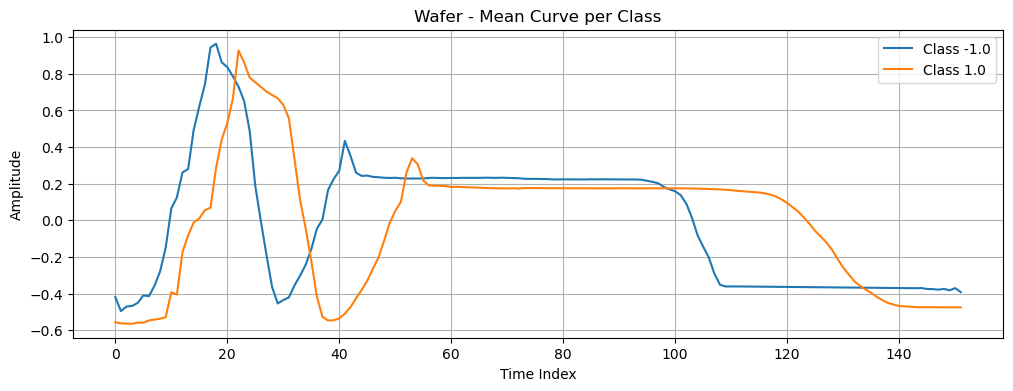

In [3]:
# 데이터 로딩
train_raw, test_raw = load_wafer(DATA_RAW_DIR)
full_data = pd.concat([train_raw, test_raw], ignore_index=True)

# mean curve 계산
mean_curves = compute_class_mean_curves(full_data)

# 시각화
plt.figure(figsize=(12, 4))
for label, mean_curve in mean_curves.items():
    plt.plot(mean_curve.values, label=f'Class {label}')

plt.title("Wafer - Mean Curve per Class")
plt.xlabel("Time Index")
plt.ylabel("Amplitude")
plt.legend()
plt.grid(True)
plt.show()

In [12]:
train_raw

,0,1,2,3,4,5,6,7,8,9,...,143,144,145,146,147,148,149,150,151,152
0,1.0,-1.602294,-1.670823,-1.693666,-1.699377,-1.699377,-1.703660,-1.703660,-1.703660,-1.703660,...,-1.145432,-1.145432,-1.145432,-1.145432,-1.145432,-1.145432,-1.145432,-1.145432,-1.145432,-1.145432
1,1.0,1.084591,1.084591,1.084591,1.065308,1.065308,1.065308,1.065308,1.065308,1.065308,...,1.065308,1.065308,1.065308,1.065308,1.065308,1.065308,1.065308,1.065308,1.065308,1.065308
2,1.0,0.362689,0.362689,0.362689,0.393316,0.362689,0.362689,0.362689,0.362689,0.362689,...,0.393316,0.393316,0.393316,0.362689,0.393316,0.393316,0.393316,0.393316,0.393316,0.393316
3,1.0,-1.094523,-1.094523,-1.094523,-1.096732,-1.094523,-1.096732,-1.094523,-1.094523,-1.094523,...,-1.096732,-1.096732,-1.096732,-1.096732,-1.096732,-1.096732,-1.096732,-1.096732,-1.096732,-1.096732
4,1.0,-1.103761,-1.103761,-1.103761,-1.103761,-1.103761,-1.103761,-1.103761,-1.103761,-1.103761,...,-1.103761,-1.103761,-1.103761,-1.103761,-1.103761,-1.103761,-1.103761,-1.103761,-1.103761,-1.103761
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,1.0,-1.621709,-1.644240,-1.652689,-1.658322,-1.658322,-1.662546,-1.658322,-1.662546,-1.662546,...,-1.111952,-1.111952,-1.111952,-1.111952,-1.111952,-1.111952,-1.111952,-1.111952,-1.111952,-1.111952
996,1.0,0.813520,0.813520,0.813520,0.813520,0.813520,0.813520,0.813520,0.813520,0.813520,...,0.758193,0.758193,0.758193,0.758193,0.758193,0.758193,0.758193,0.758193,0.758193,0.758193
997,-1.0,-0.832885,-0.977293,-0.923421,-0.953684,-0.936716,-0.946148,-0.943889,-0.938630,-0.952115,...,-0.942169,-0.942518,-0.941143,-0.943985,-0.939208,-0.946774,-0.934842,-0.953684,-0.923421,-0.977293
998,1.0,0.930389,0.930389,0.930389,0.930389,0.930389,0.930389,0.930389,0.930389,0.865309,...,0.930389,0.930389,0.930389,0.930389,0.930389,0.930389,0.930389,0.930389,0.930389,0.930389


클래스 1이 정상, 클래스 -1이 비정상

In [8]:
# 데이터셋 분할
train_incontrol, test_incontrol, test_outcontrol = split_in_out(
    train_raw,
    test_raw,
    incontrol_label=1,
    seed=1,
)

# 데이터셋 크기 출력
print(f"train_incontrol: {train_incontrol.shape}")
print(f"test_incontrol:  {test_incontrol.shape}")
print(f"test_outcontrol: {test_outcontrol.shape}")

train_incontrol: (3201, 152)
test_incontrol:  (3201, 152)
test_outcontrol: (665, 152)


In [10]:
# Z-normalization
train_incontrol = pd.DataFrame(
    z_norm_each_series(train_incontrol.values),
    index=train_incontrol.index,
    columns=train_incontrol.columns
)

test_incontrol = pd.DataFrame(
    z_norm_each_series(test_incontrol.values),
    index=test_incontrol.index,
    columns=test_incontrol.columns
)

test_outcontrol = pd.DataFrame(
    z_norm_each_series(test_outcontrol.values),
    index=test_outcontrol.index,
    columns=test_outcontrol.columns
)

In [11]:
# 데이터 저장
train_incontrol.to_csv(DATA_PROC_DIR / "wafer_train_incontrol_original.csv", index=False)
test_incontrol.to_csv(DATA_PROC_DIR / "wafer_test_incontrol_original.csv", index=False)
test_outcontrol.to_csv(DATA_PROC_DIR / "wafer_test_outcontrol_original.csv", index=False)

Selected indices: 1605 , 3127
Sakoe-Chiba radius: 20
DTW distance: 4.109779


Selected indices: 1605 , 3127
Sakoe-Chiba radius: 20
DTW distance: 4.109779


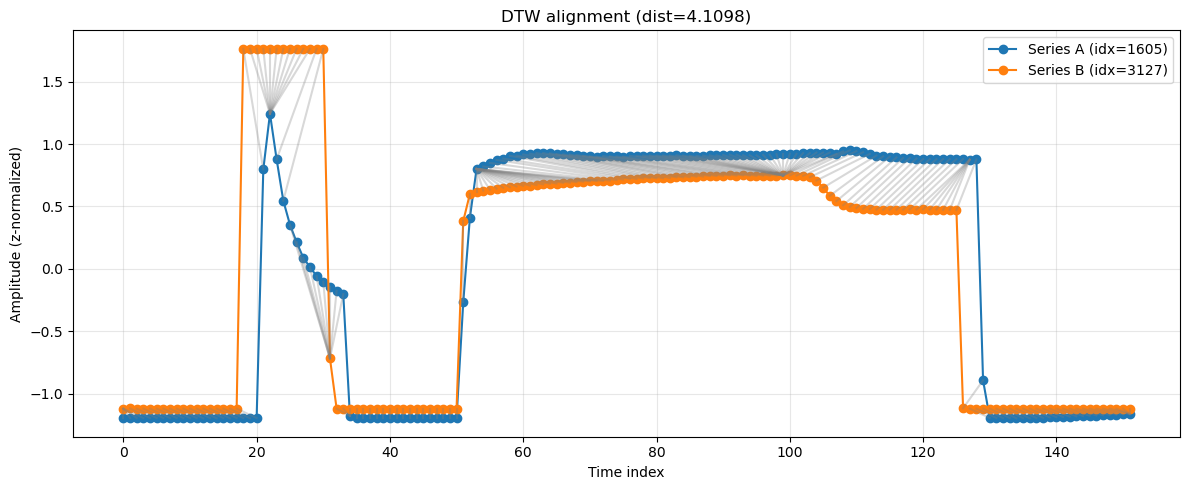

Selected indices: 1605 , 3127
Sakoe-Chiba radius: 20
DTW distance: 4.109779


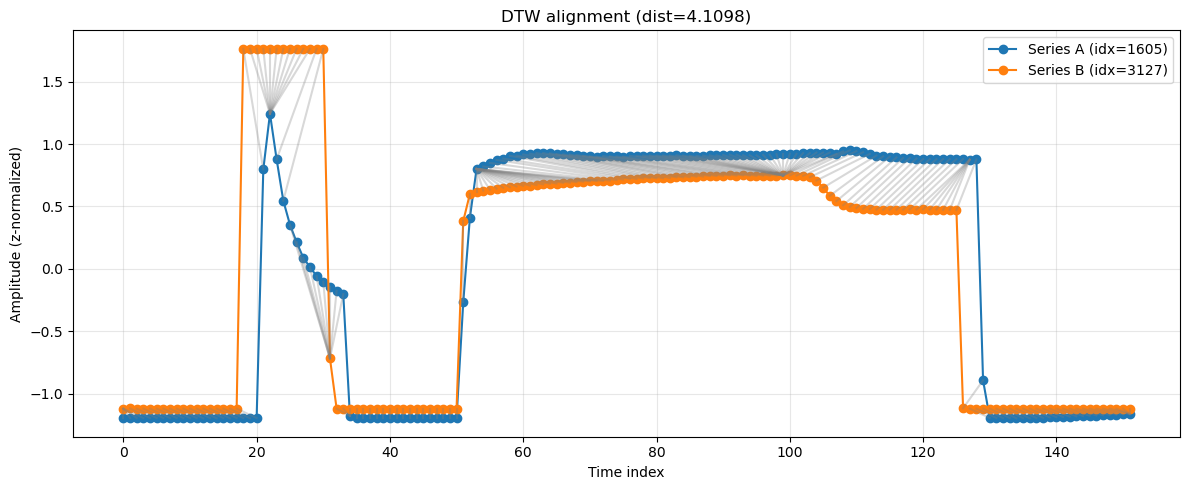

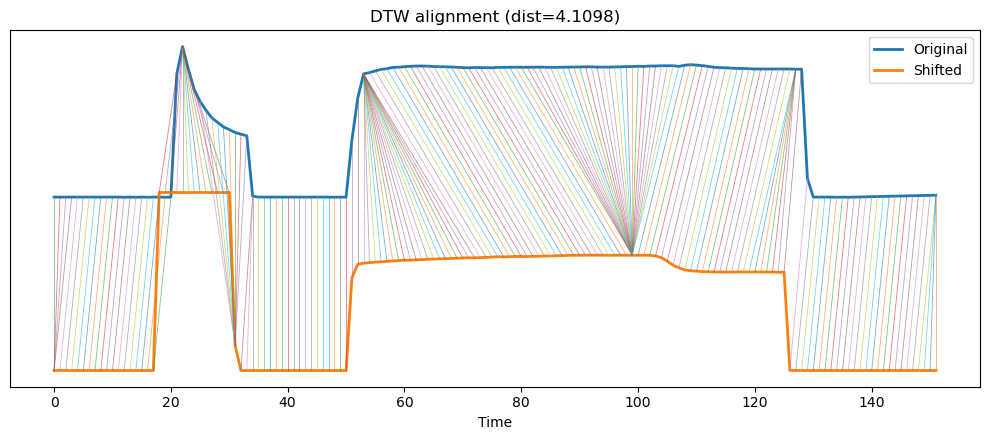

In [20]:
# 임의로 `train_incontrol`에서 데이터 2개 선택하여 DTW 거리와 정렬(mapping) 시각화
import numpy as np
import matplotlib.pyplot as plt
from dtaidistance import dtw

# 사용자 설정: Sakoe-Chiba 반경 (정수, None이면 제약 없음) — 필요하면 실행 전에 변경하세요
# 예: sakoe_radius = 10  또는 sakoe_radius = None
sakoe_radius = 20

# train_incontrol 변수가 존재하는지 확인 (이 노트북에서 이전에 생성됨을 전제로 함)
if 'train_incontrol' not in globals() and 'train_incontrol' not in locals():
    raise RuntimeError('`train_incontrol` 변수를 찾을 수 없습니다. 이전 셀에서 데이터프레임이 로드되어 있어야 합니다.')

# 랜덤 시드 지정(원하면 변경)
rng = np.random.default_rng(seed=39)

# 인덱스 두 개 선택 (중복 없음) — pandas Index에서 샘플링
idxs = rng.choice(train_incontrol.index.values, size=2, replace=False)
s1 = train_incontrol.loc[idxs[0]].values.astype(float)
s2 = train_incontrol.loc[idxs[1]].values.astype(float)

# DTW 거리와 warping path 얻기 — 프로젝트 헬퍼가 있으면 우선 사용 (window 인자 전달 시도)
try:
    # compute_dtw_distance_and_path이 sakoe/window 인자를 지원하면 전달, 아니면 기본 호출
    try:
        dist, path = compute_dtw_distance_and_path(s1, s2, window=sakoe_radius)
    except TypeError:
        dist, path = compute_dtw_distance_and_path(s1, s2)
except Exception:
    # fallback: dtaidistance의 fast 함수 사용 — window 인자를 전달할 수 있음
    if sakoe_radius is None:
        dist = dtw.distance_fast(s1, s2)
        path = dtw.warping_path(s1, s2)
    else:
        # dtaidistance는 warping_path_fast가 있을 수 있으므로 우선 시도
        try:
            dist = dtw.distance_fast(s1, s2, window=sakoe_radius)
            path = dtw.warping_path_fast(s1, s2, window=sakoe_radius)
        except Exception:
            # 마지막으로 느린 버전에 window를 전달해보거나 기본 warping_path 사용
            dist = dtw.distance(s1, s2)
            path = dtw.warping_path(s1, s2)

# warping path가 numpy array 형태로 올 수 있으므로 튜플 리스트로 변환
try:
    path = [(int(i), int(j)) for i, j in path]
except Exception:
    pass

print(f"Selected indices: {idxs[0]} , {idxs[1]}")
print(f"Sakoe-Chiba radius: {sakoe_radius}")
print(f"DTW distance: {dist:.6f}")

# 시각화: 두 시계열과 매핑선을 함께 그림
plt.figure(figsize=(12, 5))
plt.plot(s1, '-o', label=f'Series A (idx={idxs[0]})')
plt.plot(s2, '-o', label=f'Series B (idx={idxs[1]})')

# path가 list of (i,j) 튜플인지 확인 후 매핑선 그리기
for (i, j) in path:
    # 같은 플롯에 그리면 x축 인덱스가 섞여 보이지만 매칭 관계를 시각화하는 데 유용함
    plt.plot([i, j], [s1[i], s2[j]], color='gray', alpha=0.3)

plt.title(f'DTW alignment (dist={dist:.4f})')
plt.xlabel('Time index')
plt.ylabel('Amplitude (z-normalized)')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# 추가: 프로젝트 유틸의 plot_alignment가 있으면 호출해 좀 더 보기 좋은 정렬 시각화를 시도함
try:
    plot_alignment(s1, s2, path, title=f'DTW alignment (dist={dist:.4f})')
except Exception:
    pass


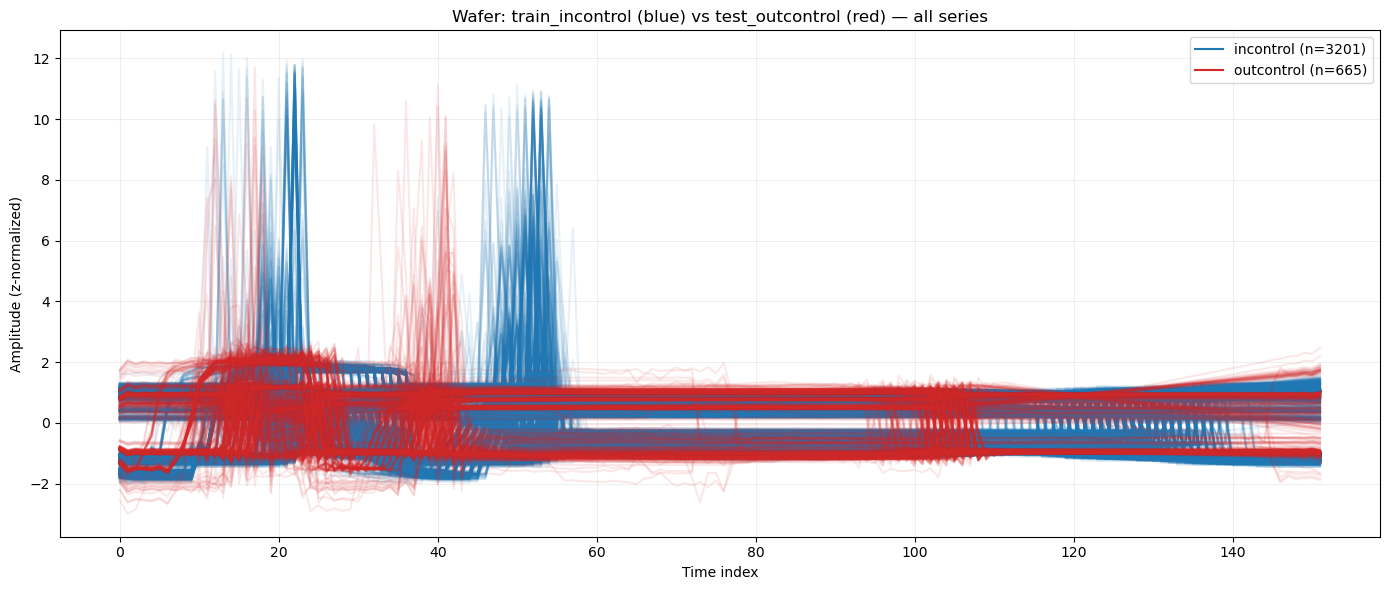

In [23]:
# 전체 시리즈 시각화: `train_incontrol`(파란색), `test_outcontrol`(빨간색)
import matplotlib.pyplot as plt
import numpy as np

# 존재 여부 확인
if 'train_incontrol' not in globals() and 'train_incontrol' not in locals():
    raise RuntimeError('`train_incontrol` 변수를 찾을 수 없습니다. 이전 셀에서 데이터프레임이 생성되어 있어야 합니다.')
if 'test_outcontrol' not in globals() and 'test_outcontrol' not in locals():
    raise RuntimeError('`test_outcontrol` 변수를 찾을 수 없습니다. 이전 셀에서 데이터프레임이 생성되어 있어야 합니다.')

# 옵션: 너무 많은 시리즈로 인해 플롯이 복잡해지면 샘플링 가능 (None = 모두 표시)
sample_limit = None  # 예: 100으로 설정하면 각 그룹에서 최대 100개 시리즈만 그림

# DataFrame -> numpy (행: 시리즈, 열: 시계열 길이)
X_in = train_incontrol.values if hasattr(train_incontrol, 'values') else np.asarray(train_incontrol)
X_out = test_outcontrol.values if hasattr(test_outcontrol, 'values') else np.asarray(test_outcontrol)

n_in = X_in.shape[0]
n_out = X_out.shape[0]

# 샘플링 인덱스 결정
if sample_limit is None:
    idx_in = np.arange(n_in)
    idx_out = np.arange(n_out)
else:
    rng = np.random.default_rng(1)
    idx_in = rng.choice(n_in, size=min(sample_limit, n_in), replace=False)
    idx_out = rng.choice(n_out, size=min(sample_limit, n_out), replace=False)

plt.figure(figsize=(14, 6))
# incontrol (파란색) — 투명도 낮게 그려 밀도 관찰 가능
for i in idx_in:
    plt.plot(X_in[int(i)], color='tab:blue', alpha=0.1)
# outcontrol (빨간색) — 강조 색상
for j in idx_out:
    plt.plot(X_out[int(j)], color='tab:red', alpha=0.1)

# 범례를 위한 더미 라인
plt.plot([], [], color='tab:blue', label=f'incontrol (n={n_in})')
plt.plot([], [], color='tab:red', label=f'outcontrol (n={n_out})')

plt.title('Wafer: train_incontrol (blue) vs test_outcontrol (red) — all series')
plt.xlabel('Time index')
plt.ylabel('Amplitude (z-normalized)')
plt.legend(loc='upper right')
plt.grid(alpha=0.2)
plt.tight_layout()
plt.show()


In [26]:
# Euclidean vs DTW 비교 실험 (삽입된 셀)
import time
import numpy as np
from scipy.spatial.distance import cdist
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# 사용자 설정: 필요 시 조정하세요
max_samples = 100      # 클래스 당 최대 샘플 수 (환경에 따라 줄이세요)
test_size = 0.3
random_seed = 1
# 기본 Sakoe-Chiba window (정수) — None 이면 제약 없음
sakoe_radius = 10

# dtaidistance 사용 가능 여부 확인
try:
    from dtaidistance import dtw
except Exception:
    dtw = None

# 데이터 존재 확인
if 'train_incontrol' not in globals() and 'train_incontrol' not in locals():
    raise RuntimeError('`train_incontrol` 변수가 없습니다. 이전 셀을 먼저 실행하세요.')
if 'test_outcontrol' not in globals() and 'test_outcontrol' not in locals():
    raise RuntimeError('`test_outcontrol` 변수가 없습니다. 이전 셀을 먼저 실행하세요.')

# numpy 배열로 변환 (행: 시리즈, 열: 시계열 길이)
X_in = train_incontrol.values if hasattr(train_incontrol, 'values') else np.asarray(train_incontrol)
X_out = test_outcontrol.values if hasattr(test_outcontrol, 'values') else np.asarray(test_outcontrol)

n_in = X_in.shape[0]
n_out = X_out.shape[0]
n_take = min(max_samples, n_in, n_out)

rng = np.random.default_rng(random_seed)
idx_in = rng.choice(n_in, size=n_take, replace=False)
idx_out = rng.choice(n_out, size=n_take, replace=False)

X = np.vstack([X_in[idx_in], X_out[idx_out]])
y = np.hstack([np.zeros(n_take, dtype=int), np.ones(n_take, dtype=int)])  # 0=incontrol, 1=outcontrol

# train/test split (stratify로 클래스 균형 유지)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_seed, stratify=y)

print(f'샘플 구성: 전체={len(y)}, train={len(y_train)}, test={len(y_test)}, 클래스당 사용={n_take}')
results = {}

# 1) Euclidean 1-NN
t0 = time.time()
D_euc = cdist(X_test, X_train, metric='euclidean')
y_pred_euc = np.array([y_train[np.argmin(D_euc[i])] for i in range(D_euc.shape[0])])
elapsed = time.time() - t0
results['euclidean'] = dict(
    accuracy=accuracy_score(y_test, y_pred_euc),
    precision=precision_score(y_test, y_pred_euc),
    recall=recall_score(y_test, y_pred_euc),
    f1=f1_score(y_test, y_pred_euc),
    time=elapsed,
)
print(f"Euclidean 1-NN — acc={results['euclidean']['accuracy']:.4f}, f1={results['euclidean']['f1']:.4f}, time={elapsed:.2f}s")

# 2) DTW 1-NN (dtw.distance_fast 사용, window 전달) — 느릴 수 있음
if dtw is None:
    print('dtaidistance 패키지가 없습니다. DTW 비교를 건너뜁니다.')
else:
    sakoe_list = [sakoe_radius, None]  # 기본값 먼저, unconstrained도 테스트
    for sakoe in sakoe_list:
        t0 = time.time()
        n_test = X_test.shape[0]
        n_train = X_train.shape[0]
        D_dtw = np.empty((n_test, n_train), dtype=float)
        for i in range(n_test):
            xi = X_test[i]
            for j in range(n_train):
                xj = X_train[j]
                # fast 함수를 우선 시도 (window 인자 지원)
                try:
                    if sakoe is None:
                        d = dtw.distance_fast(xi, xj)
                    else:
                        d = dtw.distance_fast(xi, xj, window=sakoe)
                except Exception:
                    # fallback to distance (느림)
                    try:
                        if sakoe is None:
                            d = dtw.distance(xi, xj)
                        else:
                            d = dtw.distance(xi, xj, window=sakoe)
                    except Exception:
                        d = np.inf
                D_dtw[i, j] = d
        y_pred = np.array([y_train[np.argmin(D_dtw[i])] for i in range(D_dtw.shape[0])])
        elapsed = time.time() - t0
        key = f'dtw_window_{sakoe}'
        results[key] = dict(
            accuracy=accuracy_score(y_test, y_pred),
            precision=precision_score(y_test, y_pred),
            recall=recall_score(y_test, y_pred),
            f1=f1_score(y_test, y_pred),
            time=elapsed,
        )
        print(f"DTW(window={sakoe}) 1-NN — acc={results[key]['accuracy']:.4f}, f1={results[key]['f1']:.4f}, time={elapsed:.1f}s")

# 결과 요약
print('\nSummary:')
for k, v in results.items():
    print(f"{k}: acc={v['accuracy']:.4f}, f1={v['f1']:.4f}, time={v['time']:.1f}s")

# 혼동 행렬 (Euclidean)
print('\nConfusion matrix (Euclidean):')
print(confusion_matrix(y_test, y_pred_euc))


샘플 구성: 전체=200, train=140, test=60, 클래스당 사용=100
Euclidean 1-NN — acc=1.0000, f1=1.0000, time=0.00s
DTW(window=10) 1-NN — acc=1.0000, f1=1.0000, time=0.2s
DTW(window=None) 1-NN — acc=0.9667, f1=0.9667, time=1.4s

Summary:
euclidean: acc=1.0000, f1=1.0000, time=0.0s
dtw_window_10: acc=1.0000, f1=1.0000, time=0.2s
dtw_window_None: acc=0.9667, f1=0.9667, time=1.4s

Confusion matrix (Euclidean):
[[30  0]
 [ 0 30]]
DTW(window=None) 1-NN — acc=0.9667, f1=0.9667, time=1.4s

Summary:
euclidean: acc=1.0000, f1=1.0000, time=0.0s
dtw_window_10: acc=1.0000, f1=1.0000, time=0.2s
dtw_window_None: acc=0.9667, f1=0.9667, time=1.4s

Confusion matrix (Euclidean):
[[30  0]
 [ 0 30]]
